## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import PIL.Image as PilImage

In [3]:
path = Path('/home/des/dev/src/segmentation')

In [4]:
path_lbl = path/'newlabels'
path_img = path/'images'

path_lbl

PosixPath('/home/des/dev/src/segmentation/newlabels')

In [5]:
def getClassValues(label_names):

    containedValues = set([])

    for i in range(len(label_names)):
        tmp = open_mask(label_names[i])
        tmp = tmp.data.numpy().flatten()
        tmp = set(tmp)
        containedValues = containedValues.union(tmp)
    
    return list(containedValues)

def replaceMaskValuesFromZeroToN(mask, 
                                 containedValues):

    numberOfClasses = len(containedValues)
    newMask = np.zeros(mask.shape)

    for i in range(numberOfClasses):
        newMask[mask == containedValues[i]] = i
    
    return newMask

def convertMaskToPilAndSave(mask, 
                            saveTo):

    imageSize = mask.squeeze().shape

    im = PilImage.new('L',(imageSize[1],imageSize[0]))
    im.putdata(mask.astype('uint8').ravel())
    im.save(saveTo)

def convertMasksToGrayscaleZeroToN(pathToLabels,
                                   saveToPath):

    label_names = get_image_files(pathToLabels)
    containedValues = getClassValues(label_names)

    for currentFile in label_names:
        currentMask = open_mask(currentFile).data.numpy()
        convertedMask = replaceMaskValuesFromZeroToN(currentMask, containedValues)
        convertMaskToPilAndSave(convertedMask, saveToPath/f'{currentFile.name}')
    
    print('Conversion finished!')

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/des/dev/src/segmentation/images/frame_000086.jpg'),
 PosixPath('/home/des/dev/src/segmentation/images/frame_000015.jpg'),
 PosixPath('/home/des/dev/src/segmentation/images/frame_000087.jpg')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/des/dev/src/segmentation/newlabels/frame_000021.png'),
 PosixPath('/home/des/dev/src/segmentation/newlabels/frame_000025.png'),
 PosixPath('/home/des/dev/src/segmentation/newlabels/frame_000022.png')]

In [9]:
#new_labels = Path('/home/des/dev/src/segmentation/newlabels')

In [10]:
#convertMasksToGrayscaleZeroToN(path_lbl, new_labels)

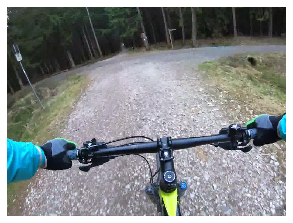

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [12]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [13]:
#doc(open_mask)

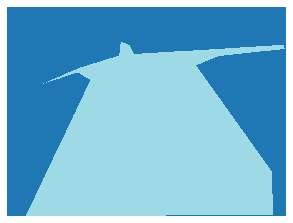

In [14]:
mask = open_mask(get_y_fn(img_f), div=False)
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1080, 1440]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [16]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Road', 'Background'], dtype='<U10')

In [17]:
mask.data.unique()


tensor([0, 1])

## Datasets

In [18]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 10799MB of GPU RAM free


In [19]:
classes2={'Road':38, 'Background':0}

In [20]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=classes2))

In [21]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

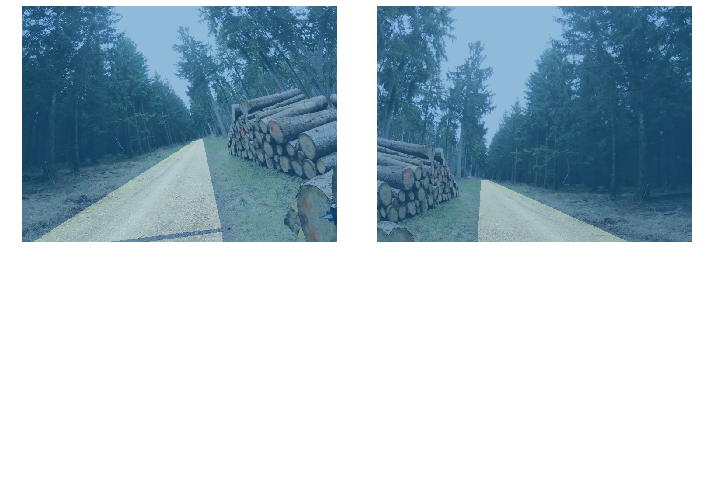

In [22]:
data.show_batch(2, figsize=(10,7))

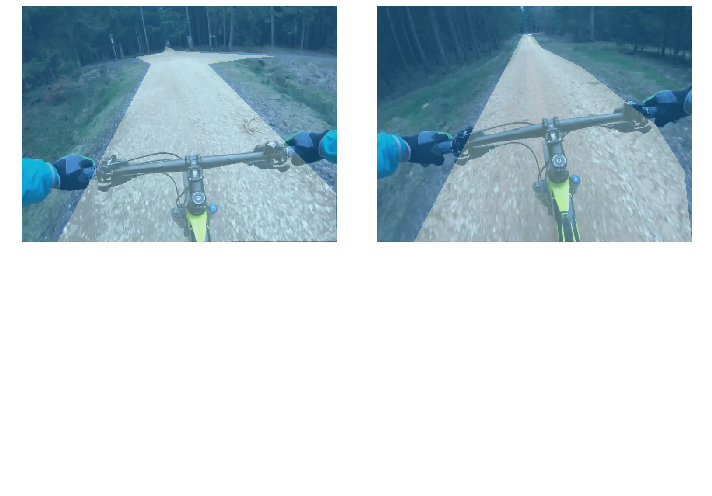

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [25]:
#metrics=acc_camvid
# metrics=accuracy
metrics=seg_accuracy

In [27]:
wd=1e-2

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


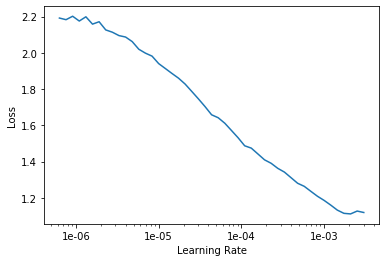

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
lr=3e-4

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,seg_accuracy,time
0,1.209831,0.650712,0.677062,00:08
1,0.793338,0.416541,0.795680,00:06
2,0.580054,0.435386,0.813810,00:06
3,0.544401,0.370708,0.851893,00:06
4,0.460046,0.231492,0.900220,00:06
5,0.366266,0.183416,0.923768,00:06
6,0.295966,0.215807,0.908839,00:06
7,0.244080,0.181598,0.923546,00:06
8,0.204735,0.134098,0.945564,00:06
9,0.188740,0.166432,0.930088,00:06


In [31]:
learn.save('stage-1')

In [32]:
learn.load('stage-1');

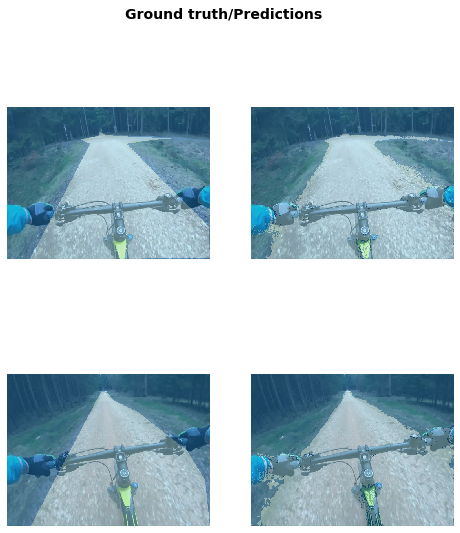

In [33]:
learn.show_results(rows=3, figsize=(8,9))

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(lr/400,lr/4)

In [36]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.102585,0.125055,0.944263,00:07
1,0.099859,0.111842,0.953078,00:06
2,0.095023,0.125973,0.946408,00:06
3,0.091704,0.105880,0.953760,00:06
4,0.086129,0.096332,0.959460,00:06
5,0.079374,0.099061,0.960260,00:06
6,0.072361,0.086916,0.965683,00:06
7,0.070943,0.089862,0.963867,00:06
8,0.068668,0.080636,0.968401,00:06
9,0.065713,0.091130,0.966584,00:06


In [37]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [29]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=3
#else:           bs=1
bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 10322MB of GPU RAM free


In [30]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [31]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [32]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


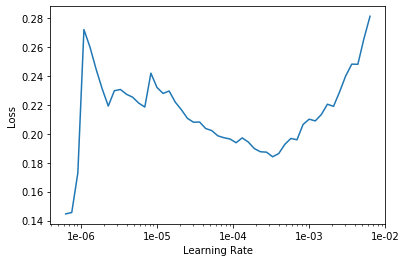

In [33]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=5e-4

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.137167,0.175779,0.943972,00:27
1,0.136049,0.164889,0.948788,00:26
2,0.128178,0.154753,0.954062,00:26
3,0.131685,0.171397,0.944272,00:26
4,0.125244,0.188183,0.932972,00:26
5,0.116461,0.208157,0.933904,00:26
6,0.103899,0.123097,0.951882,00:25
7,0.099238,0.229979,0.939935,00:26
8,0.116877,0.137737,0.945715,00:26
9,0.117504,0.129035,0.955821,00:27


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big');

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(1e-6,lr/10)

In [42]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.085829,0.113758,0.959007,00:27
1,0.084502,0.121558,0.954709,00:26
2,0.076958,0.112085,0.962249,00:26
3,0.071883,0.112176,0.959946,00:26
4,0.070279,0.112777,0.959493,00:26
5,0.064891,0.107009,0.961886,00:26
6,0.057691,0.097589,0.964123,00:26
7,0.053810,0.105052,0.961838,00:26
8,0.050962,0.110796,0.960674,00:27
9,0.050341,0.108154,0.961096,00:26


In [43]:
learn.save('stage-2-big')

In [44]:
learn.load('stage-2-big');

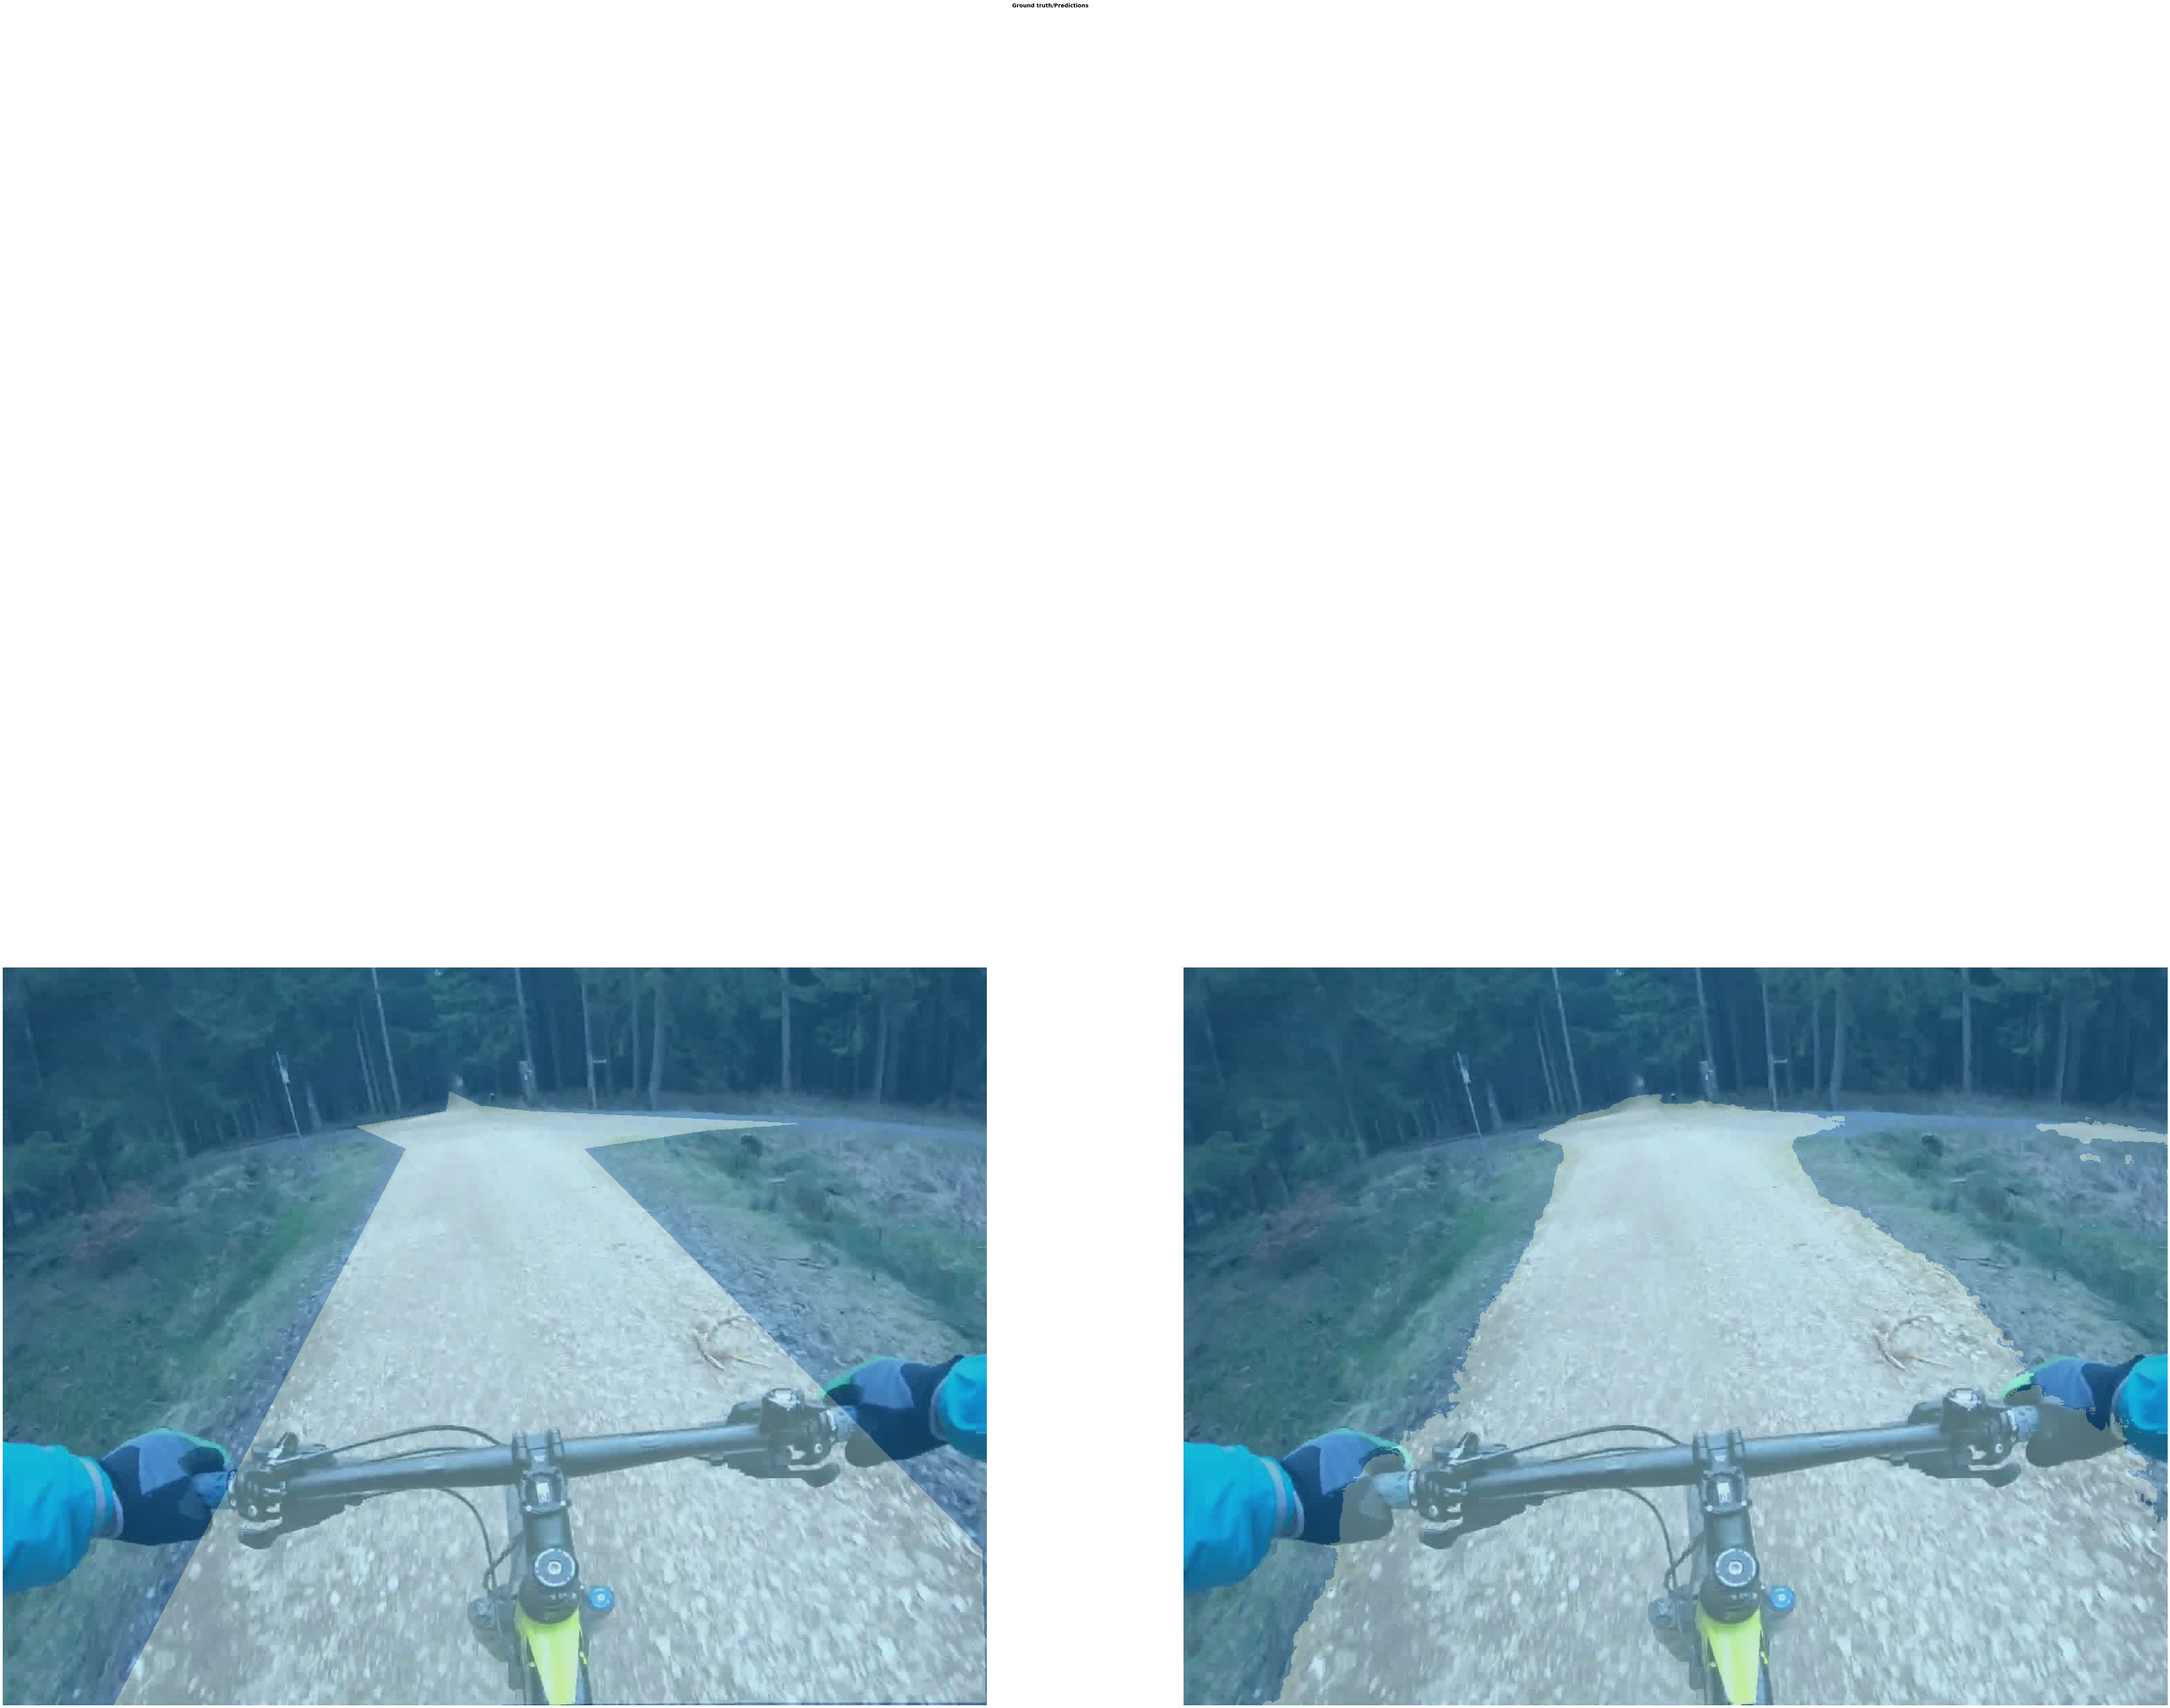

In [49]:
learn.show_results(rows=1, figsize=(100,100))

## fin